In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import keras,os
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import np_utils
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create Dataset

In [ ]:
train_list_filenames=[]
train_list_labels=[]
dstpath='/content/drive/MyDrive/Proyect Final Vision/train'
test_df = pd.read_csv('/content/drive/MyDrive/Proyect Final Vision/test.txt', sep=" ", header=None)
test_df.columns=['patient id', 'filenames', 'labels', 'data source' ]
test_df=test_df.drop(['patient id', 'data source'], axis=1 )
print (test_df.head())
train_txt= open("/content/drive/MyDrive/Proyect Final Vision/train.txt","r")
train_list=train_txt.readlines()
for line in train_list:
    split=line.split(' ')    
    if len(split)>4:        
        fname=os.path.join(dstpath, split[2])        
        label=split [3]
    else:        
        fname=os.path.join(dstpath, split[1])
        label=split[2]
    train_list_filenames.append(fname)
    train_list_labels.append(label)
Ftrseries=pd.Series(train_list_filenames, name='filenames')
Ltrseries=pd.Series(train_list_labels, name='labels')
df=pd.concat([Ftrseries, Ltrseries], axis=1)
print (df.head())
balance=df['labels'].value_counts()
print (balance)

                                   filenames    labels
0  MIDRC-RICORD-1C-419639-003251-46647-0.png  positive
1  MIDRC-RICORD-1C-419639-001464-39871-0.png  positive
2  MIDRC-RICORD-1C-419639-000918-78965-0.png  positive
3  MIDRC-RICORD-1C-419639-003318-64285-0.png  positive
4  MIDRC-RICORD-1C-419639-001015-81591-0.png  positive
                                           filenames    labels
0  /content/drive/MyDrive/Proyect Final Vision/tr...  negative
1  /content/drive/MyDrive/Proyect Final Vision/tr...  negative
2  /content/drive/MyDrive/Proyect Final Vision/tr...  negative
3  /content/drive/MyDrive/Proyect Final Vision/tr...  negative
4  /content/drive/MyDrive/Proyect Final Vision/tr...  negative
negative    13793
positive     2158
Name: labels, dtype: int64


In [ ]:
#balancear el dataset
file_count = 2158
samples = []
for category in df['labels'].unique():    
    category_slice = df.query("labels == @category")    
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (  df['labels'].value_counts())
print (len(df))

negative    2158
positive    2158
Name: labels, dtype: int64
4316


In [ ]:
#dividir el dataset en entrenamiento y validacion
tsplit=.9
train_df, valid_df=train_test_split(df, train_size=tsplit, shuffle=True, random_state=123)

# Create Generators

In [ ]:
def scalar(img):
  return img/255

In [ ]:
gen=ImageDataGenerator(preprocessing_function=scalar)

In [ ]:
train_gen=gen.flow_from_dataframe( train_df, x_col='filenames', y_col='labels', target_size=(224, 224), class_mode='binary',
                                    color_mode='rgb', shuffle=False, batch_size=60)

Found 3884 validated image filenames belonging to 2 classes.


In [ ]:
valid_gen=gen.flow_from_dataframe( valid_df, x_col='filenames', y_col='labels', target_size=(224, 224), class_mode='binary',
                                    color_mode='rgb', shuffle=False, batch_size=60)

Found 432 validated image filenames belonging to 2 classes.


# Define steps

In [ ]:
nb_train_sample = train_df.shape[0] * 0.9
nb_validation_sample = train_df.shape[0] - nb_train_sample
nb_test_sample = valid_df.shape[0]
print(nb_train_sample)
print(nb_validation_sample)
print(nb_test_sample)

3495.6
388.4000000000001
432


In [ ]:
def get_steps(num_samples, batch_size):

    if (num_samples % batch_size) > 0:

        return (num_samples // batch_size) + 2

    else:

        return num_samples // batch_size

# Define the model

In [ ]:
model_path = '/content/drive/MyDrive/Proyect Final Vision/model/vgg16-final.hdf5'

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 1,verbose = 1,factor = 0.50, min_lr = 1e-10)
early = EarlyStopping(min_delta=0, patience=5, verbose=1, mode='auto')
mc = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
image_input = Input(shape=(224, 224, 3))

base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224) + (3,)
)

model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


# Fit the model

In [ ]:
model_history = model.fit(  
    train_gen,
    epochs=100,
    validation_data=valid_gen,
    steps_per_epoch=60,
    validation_steps=get_steps(nb_validation_sample, 60), verbose=1, callbacks=[ lrd, mc, early])

Epoch 1/100
60/60 [==============================] - 1457s 24s/step - loss: 0.3739 - accuracy: 0.8214 - val_loss: 0.2348 - val_accuracy: 0.9190

Epoch 00001: val_loss improved from inf to 0.23481, saving model to /content/drive/MyDrive/Proyect Final Vision/model/vgg16-final.hdf5
Epoch 2/100
60/60 [==============================] - 227s 4s/step - loss: 0.2296 - accuracy: 0.9116 - val_loss: 0.2040 - val_accuracy: 0.9144

Epoch 00002: val_loss improved from 0.23481 to 0.20396, saving model to /content/drive/MyDrive/Proyect Final Vision/model/vgg16-final.hdf5
Epoch 3/100
60/60 [==============================] - 128s 2s/step - loss: 0.1960 - accuracy: 0.9255 - val_loss: 0.1854 - val_accuracy: 0.9306

Epoch 00003: val_loss improved from 0.20396 to 0.18544, saving model to /content/drive/MyDrive/Proyect Final Vision/model/vgg16-final.hdf5
Epoch 4/100
60/60 [==============================] - 130s 2s/step - loss: 0.1832 - accuracy: 0.9316 - val_loss: 0.1619 - val_accuracy: 0.9375

Epoch 00004: 

In [ ]:
loaded_model  = tf.keras.models.load_model('/content/drive/My Drive/Proyect Final Vision/model/vgg16-model.hdf5')

# Confusion matrix

In [ ]:
preds=loaded_model.predict(valid_gen, batch_size=60, steps=get_steps(nb_validation_sample, 60), verbose=1)
y_preds =  np.rint(preds)
y_true = valid_gen.classes

8/8 [==============================] - 134s 16s/step


Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       215
           1       0.96      0.95      0.96       217

    accuracy                           0.96       432
   macro avg       0.96      0.96      0.96       432
weighted avg       0.96      0.96      0.96       432



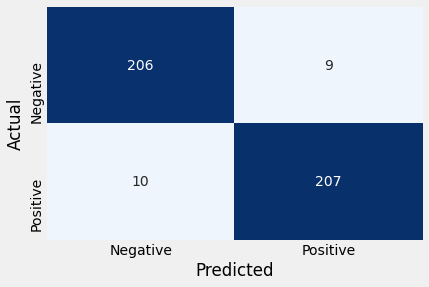

In [ ]:
cm = confusion_matrix(y_true, y_preds)
x_axis_labels=["Negative","Positive"]
y_axis_labels=["Negative","Positive"]
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,xticklabels=x_axis_labels, yticklabels=y_axis_labels )
plt.xlabel("Predicted")
plt.ylabel("Actual")
clr=classification_report(y_true,y_preds)
print("Classification Report:\n----------------------\n", clr)

In [ ]:
valid_gen.reset()
preds=loaded_model.predict(valid_gen, batch_size=60, steps=get_steps(nb_validation_sample, 60), verbose=1)

8/8 [==============================] - 134s 16s/step


# Roc curve

In [ ]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(valid_gen.classes, preds)
auc_rf = auc(fpr_rf, tpr_rf)

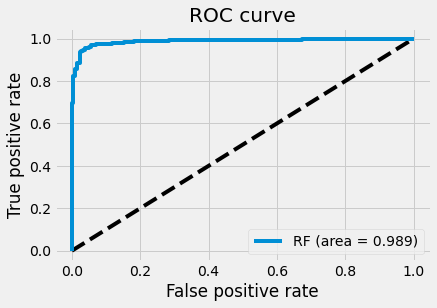

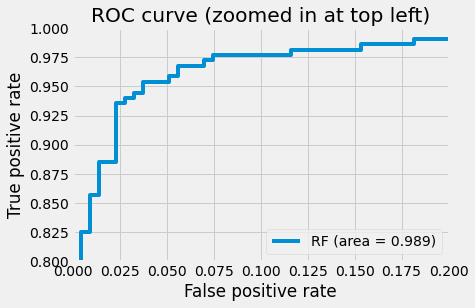

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()